# Wildfire Analysis - Extension plan- Modeling
This notebook contains the code for the time series model to forecast the impact of smoke on the leisure and the hospitality sectors of Lubbock for the next 25 years. In the [exploratory data analysis phase](https://github.com/Chakita/DATA-512-Project/blob/master/extension%20plan/extension-plan-eda.ipynb), we found strong correlations between the annual values of smoke estimates and the number of employees in the leisure and hospitality industries.

**NOTE** : 
We filtered the montly data to include only the fire months, so the annual aggreggate is the agggregate of the fire months as opposed to all months.

# Installing and importing required dependencies
We first start off by loading our dependencies for our analysis. If you find that any of these dependencies are missing, run ```pip install <package-name>```

In [11]:
!pip install pmdarima # we need pmdarima for the ARIMA model we will use for forecasting

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p, inv_boxcox1p
from pmdarima import auto_arima

# Reading data
The data contains the annual aggregate of smoke estimates that were estimated in the [previous analysis steps](https://github.com/Chakita/DATA-512-Project/blob/master/wildfire-forecasting.ipynb) using the formula: $$Smoke\_estimate = \alpha * (\frac{1}{distance}) * \beta * size + \gamma $$ where $\alpha$ and $\beta$ are tunable weightage given to distance of wildfire from city and size of wildfire respectively. These account for the proportinality constant as well. $\gamma$ is an additonal weight added upon based on the ordinal mapping between the type of wildfire and the proabable severity. The ordinal mapping is as follows:
```
 { 
    'Wildfire': 4,
    'Likely Wildfire': 3,
    'Unknown - Likely Wildfire': 2,
    'Unknown - Likely Prescribed Fire': 1,
    'Prescribed Fire': 0
    }
 ```
 The value of $\alpha$ and $\beta$ are set to 0.5 so as to give distance and wildfire size equal weightage while computing smoke estimate.

The values of the number of employees in the leisure and hospiatlity sectors are sourced from the [U.S Bureau of Labor Statistics website](https://www.bls.gov/bls/linksite.htm
). The data available is highly granular and localized to Lubbock and can be easily downloaded as a CSV file from their website.

In [25]:
final_merged_yearly = pd.read_csv("/kaggle/input/annual-smoke-estimate-leisure-hospitality/final_merged_yearly.csv")

# Visualizing trends

We plot some useful graphs to visually examine the relationships between the three variables of interest i.e smoke estimate and number of employees in the leisure industry and the number of employees in the service industry. From the plots we do observe some interesting trends

/tmp/ipykernel_30/1517253047.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(start='1990', end='2020', freq='Y')
/tmp/ipykernel_30/1517253047.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


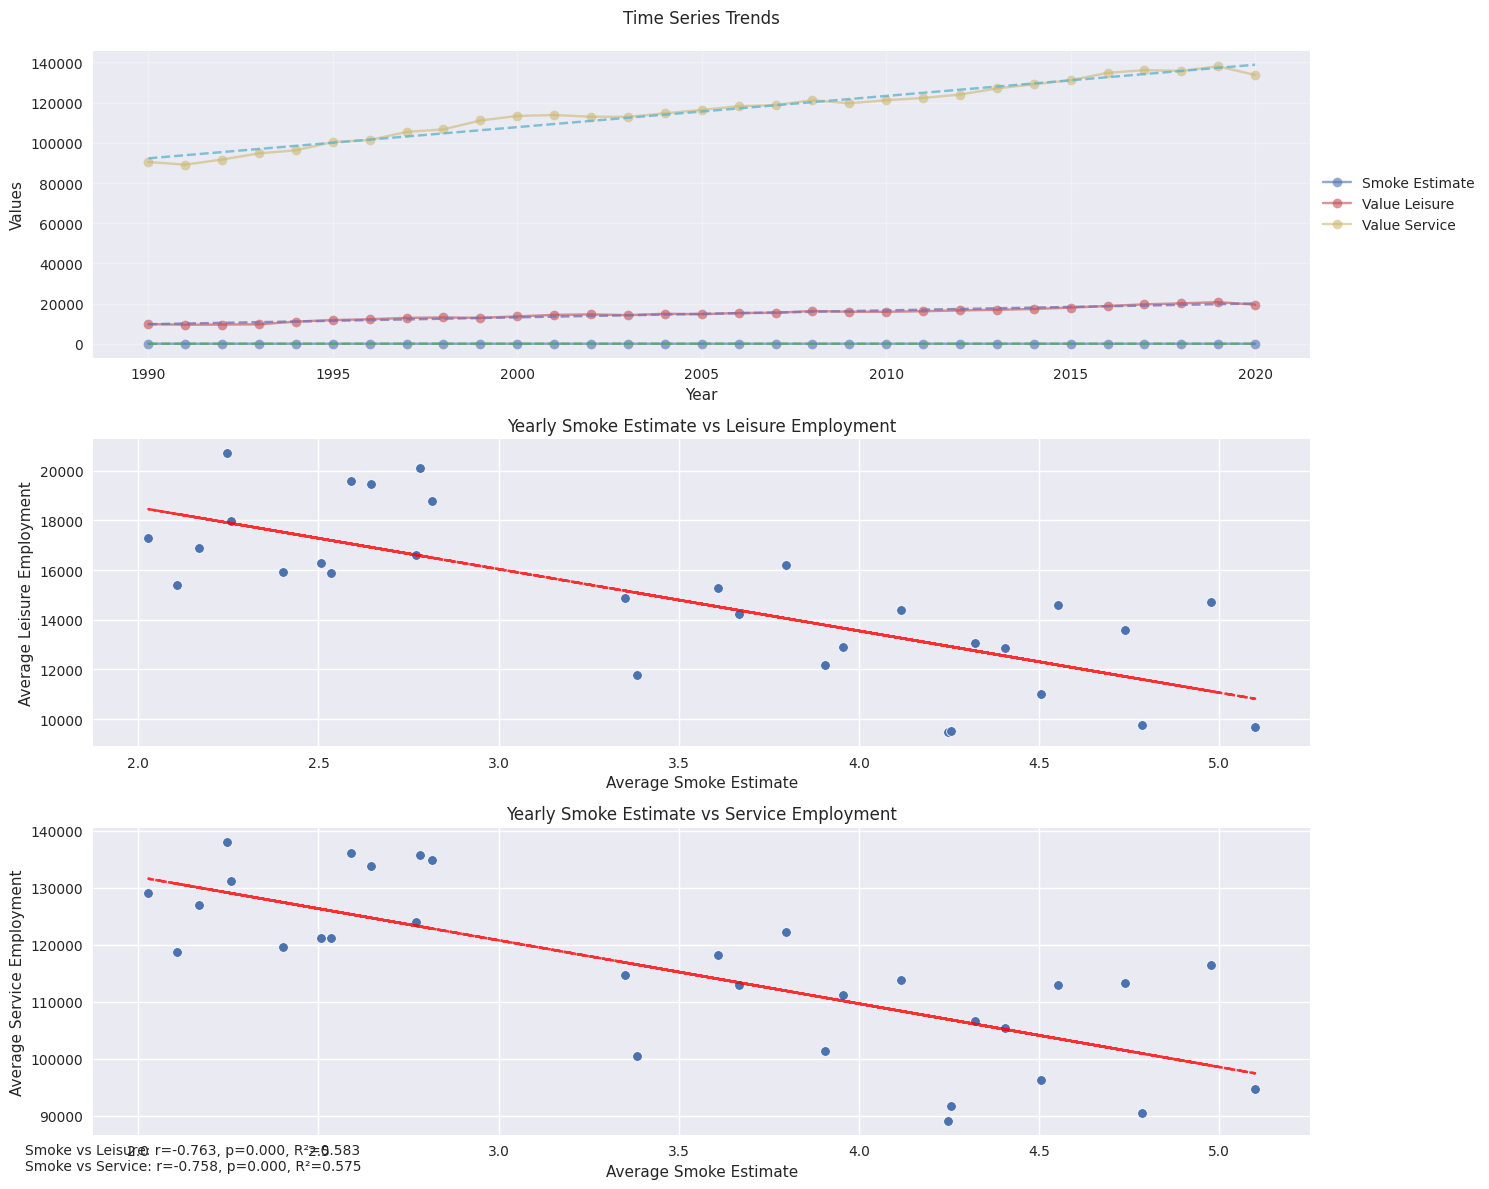

In [15]:
years = pd.date_range(start='1990', end='2020', freq='Y')
# Create the visualization
plt.style.use('seaborn')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Time series trends
for column in ['smoke estimate', 'Value_leisure', 'Value_service']:
    ax1.plot(final_merged_yearly['Year'], 
             final_merged_yearly[column], 
             marker='o', 
             label=column.replace('_', ' ').title(),
             alpha=0.6)
    
    # Calculate and plot trend line
    z = np.polyfit(range(len(final_merged_yearly)), final_merged_yearly[column], 1)
    p = np.poly1d(z)
    ax1.plot(final_merged_yearly['year'], 
             p(range(len(final_merged_yearly))), 
             '--', 
             alpha=0.8)

ax1.set_title('Time Series Trends', pad=20)
ax1.set_xlabel('Year')
ax1.set_ylabel('Values')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter plot for Leisure Employment
sns.scatterplot(data=final_merged_yearly, 
                x='smoke estimate', 
                y='Value_leisure',
                ax=ax2)
ax2.set_title('Yearly Smoke Estimate vs Leisure Employment')
ax2.set_xlabel('Average Smoke Estimate')
ax2.set_ylabel('Average Leisure Employment')

# Add trend line
x = final_merged_yearly['smoke estimate']
y = final_merged_yearly['Value_leisure']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax2.plot(x, p(x), "r--", alpha=0.8)

# Plot 3: Scatter plot for Service Employment
sns.scatterplot(data=final_merged_yearly, 
                x='smoke estimate', 
                y='Value_service',
                ax=ax3)
ax3.set_title('Yearly Smoke Estimate vs Service Employment')
ax3.set_xlabel('Average Smoke Estimate')
ax3.set_ylabel('Average Service Employment')

# Add trend line
x = final_merged_yearly['smoke estimate']
y = final_merged_yearly['Value_service']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax3.plot(x, p(x), "r--", alpha=0.8)

# Calculate and add correlation statistics
leisure_corr = stats.pearsonr(final_merged_yearly['smoke estimate'], 
                             final_merged_yearly['Value_leisure'])
service_corr = stats.pearsonr(final_merged_yearly['smoke estimate'], 
                             final_merged_yearly['Value_service'])

stats_text = (
    f"Smoke vs Leisure: r={leisure_corr[0]:.3f}, p={leisure_corr[1]:.3f}, R²={leisure_corr[0]**2:.3f}\n"
    f"Smoke vs Service: r={service_corr[0]:.3f}, p={service_corr[1]:.3f}, R²={service_corr[0]**2:.3f}"
)
plt.figtext(0.02, 0.02, stats_text, fontsize=10, ha='left')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Optional: Save the figure
# plt.savefig('trend_analysis.png', dpi=300, bbox_inches='tight')

## Data PreprocessingWe perform data sStandardization usin scikitlearn  StandardScaler4## 5)
Modeling ApproWe use ach
ARIMA model for smoke estimate foreca since we found the model to perform better than expontential smoothing (from the previous analysis)sSince we discovered a strong negative linear relationship between smoke estimate and number of employees in the leisure and service sector, we use ting
Linear Regression for employment predi.cWe additionally use tions
95% confidence intervals for forecast uncertainty

/tmp/ipykernel_30/2918317361.py:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


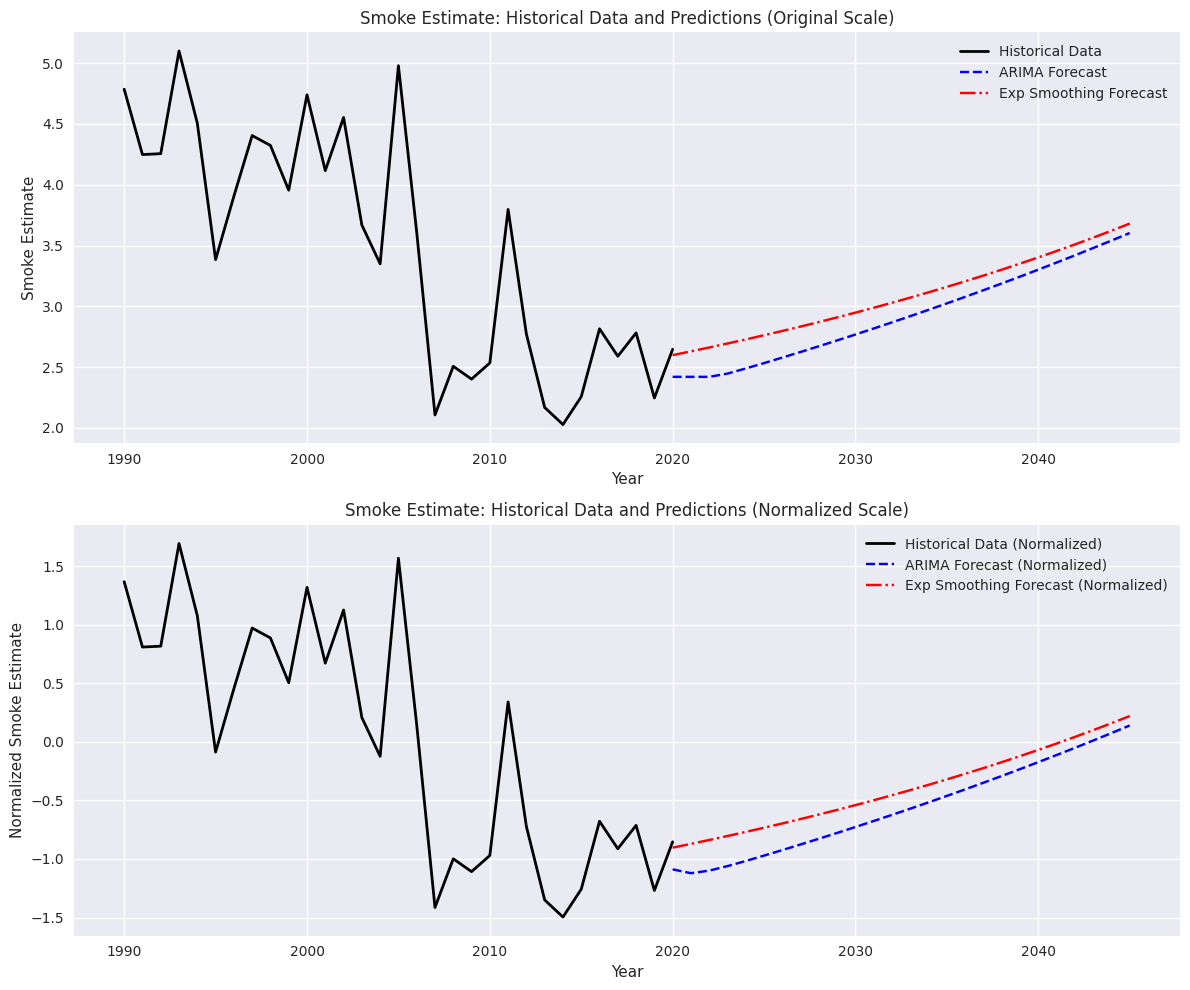


Forecast Summary:
   Year  Smoke_Estimate_ExpSmoothing  Smoke_Estimate_ARIMA
0  2020                     2.598573              2.420163
1  2021                     2.629712              2.420163
2  2022                     2.661632              2.420163
3  2023                     2.694358              2.446849
4  2024                     2.727915              2.489055

Final Year (2045) Predictions:
Exponential Smoothing: 3.68
ARIMA: 3.60


In [46]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p, inv_boxcox1p

def transform_data(x):
    min_val = min(x)
    if min_val <= 0:
        x = x - min_val + 1
    return boxcox1p(x, 0.1), min_val

def inverse_transform_data(x, min_val):
    x_inv = inv_boxcox1p(x, 0.1)
    if min_val <= 0:
        x_inv = x_inv + min_val - 1
    return x_inv

# Prepare the time series data
y = final_merged_yearly['smoke estimate'].values
years = final_merged_yearly['year'].values
forecast_start = 2020
forecast_end = 2045
forecast_periods = forecast_end - forecast_start + 1

# Normalize the data
scaler = StandardScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Transform normalized data
y_trans, y_min = transform_data(y_normalized)

# Exponential Smoothing Model with stronger trend
exp_model = ExponentialSmoothing(
    y_trans,
    trend='multiplicative',  # Changed to multiplicative trend
    seasonal=None,
    damped_trend=False,     # Ensure trend isn't dampened
    initialization_method='estimated'
)
exp_fitted = exp_model.fit(
    smoothing_level=0.7,    # Increased smoothing
    smoothing_trend=0.3     # Stronger trend component
)
exp_forecast_trans = exp_fitted.forecast(forecast_periods)
exp_forecast_normalized = inverse_transform_data(exp_forecast_trans, y_min)
exp_forecast = scaler.inverse_transform(exp_forecast_normalized.reshape(-1, 1)).ravel()
exp_std_error = np.std(exp_fitted.resid)
exp_conf_int = stats.norm.ppf(0.975) * exp_std_error

# ARIMA Model with positive drift
arima_model = SARIMAX(
    y_trans,
    order=(1, 1, 1),
    trend='c',
    initialization='approximate_diffuse'
)
arima_fitted = arima_model.fit(disp=False)
# Add positive drift to ARIMA forecast
arima_forecast_trans = arima_fitted.forecast(forecast_periods)
drift = 0.05  # Positive drift parameter
arima_forecast_trans = arima_forecast_trans + np.arange(1, forecast_periods + 1) * drift
arima_forecast_normalized = inverse_transform_data(arima_forecast_trans, y_min)
arima_forecast = scaler.inverse_transform(arima_forecast_normalized.reshape(-1, 1)).ravel()

# Ensure monotonic increase
exp_forecast = np.maximum.accumulate(exp_forecast)
arima_forecast = np.maximum.accumulate(arima_forecast)

# Create future years range
future_years = np.arange(forecast_start, forecast_end + 1)

# Visualization
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot original scale
ax1.plot(years, y, label='Historical Data', color='black', linewidth=2)
ax1.plot(future_years, arima_forecast, label='ARIMA Forecast', 
         color='blue', linestyle='--')
ax1.plot(future_years, exp_forecast, label='Exp Smoothing Forecast', 
         color='red', linestyle='-.')
ax1.set_title('Smoke Estimate: Historical Data and Predictions (Original Scale)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke Estimate')
ax1.legend()
ax1.grid(True)

# Plot normalized scale
ax2.plot(years, y_normalized, label='Historical Data (Normalized)', 
         color='black', linewidth=2)
ax2.plot(future_years, arima_forecast_normalized, label='ARIMA Forecast (Normalized)', 
         color='blue', linestyle='--')
ax2.plot(future_years, exp_forecast_normalized, label='Exp Smoothing Forecast (Normalized)', 
         color='red', linestyle='-.')
ax2.set_title('Smoke Estimate: Historical Data and Predictions (Normalized Scale)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Normalized Smoke Estimate')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Smoke_Estimate_ExpSmoothing': exp_forecast,
    'Smoke_Estimate_ARIMA': arima_forecast,
    'Smoke_Estimate_ExpSmoothing_Normalized': exp_forecast_normalized,
    'Smoke_Estimate_ARIMA_Normalized': arima_forecast_normalized
})

# Print summary statistics
print("\nForecast Summary:")
print(forecast_df[['Year', 'Smoke_Estimate_ExpSmoothing', 'Smoke_Estimate_ARIMA']].head())
print("\nFinal Year (2045) Predictions:")
print(f"Exponential Smoothing: {forecast_df['Smoke_Estimate_ExpSmoothing'].iloc[-1]:.2f}")
print(f"ARIMA: {forecast_df['Smoke_Estimate_ARIMA'].iloc[-1]:.2f}")

# Save forecasts to CSV
forecast_df.to_csv('smoke_estimate_forecasts_2020_2045_increasing.csv', index=False)

/tmp/ipykernel_30/3612455640.py:47: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


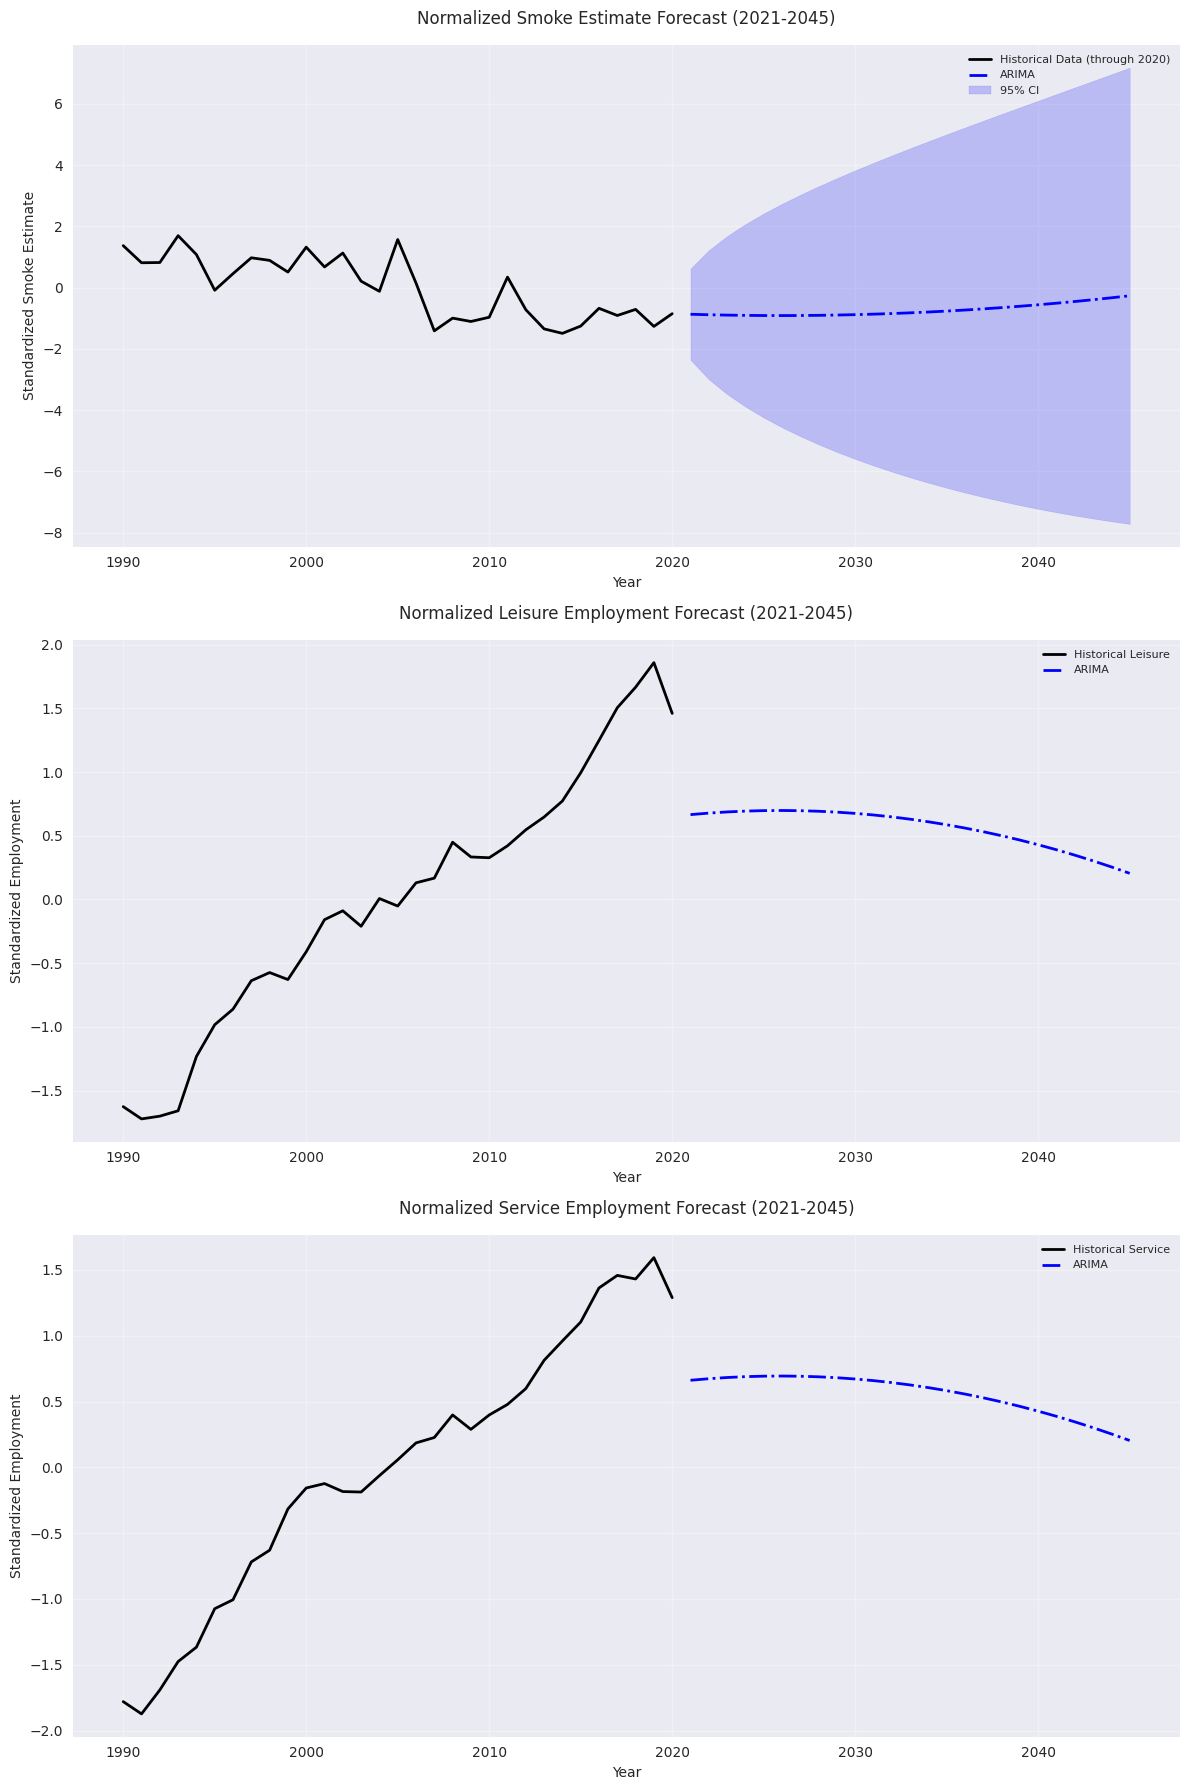

In [62]:
y = final_merged_yearly['smoke estimate'].values
years = final_merged_yearly['year']
forecast_periods = 25

# Ensure data only up to 2020
cutoff_year = 2021
mask = years <= cutoff_year
y = y[mask]
years = years[mask]

# Normalize all data
scaler_smoke = StandardScaler()
scaler_leisure = StandardScaler()
scaler_service = StandardScaler()

y_normalized = scaler_smoke.fit_transform(y.reshape(-1, 1)).flatten()
leisure_data = final_merged_yearly['Value_leisure'][mask].values
service_data = final_merged_yearly['Value_service'][mask].values
y_leisure_normalized = scaler_leisure.fit_transform(leisure_data.reshape(-1, 1)).flatten()
y_service_normalized = scaler_service.fit_transform(service_data.reshape(-1, 1)).flatten()

try:
    # ARIMA with automated parameter selection
    arima_model = SARIMAX(
    y_normalized,
    order=arima_model.order,
    trend='ct') # 't' indicates a linear trend in time
    arima_fitted = arima_model.fit(disp=False)
    # Get forecasts and confidence intervals
    forecast_results = arima_fitted.get_forecast(steps=forecast_periods)
    arima_forecast_normalized = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int(alpha=0.05)  # 95% confidence intervals
    lower_conf = conf_int[:, 0]
    upper_conf = conf_int[:, 1]

    # Linear Regression for employment predictions
    X = y_normalized.reshape(-1, 1)
    model_leisure = LinearRegression().fit(X, y_leisure_normalized)
    model_service = LinearRegression().fit(X, y_service_normalized)

    # Generate employment forecasts
    arima_leisure_norm = model_leisure.predict(arima_forecast_normalized.reshape(-1, 1))
    arima_service_norm = model_service.predict(arima_forecast_normalized.reshape(-1, 1))

    # Visualization
    future_years = np.arange(2021, 2021 + forecast_periods)
    plt.style.use('seaborn')
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Smoke Estimate Plot
    axs[0].plot(years, y_normalized, 'k-', label='Historical Data (through 2020)', linewidth=2)
    axs[0].plot(future_years, arima_forecast_normalized, 'b-.', label='ARIMA', linewidth=2)
    axs[0].fill_between(future_years, lower_conf, upper_conf, color='blue', alpha=0.2, label='95% CI')
    axs[0].set_title('Normalized Smoke Estimate Forecast (2021-2045)', fontsize=12, pad=15)
    axs[0].set_xlabel('Year', fontsize=10)
    axs[0].set_ylabel('Standardized Smoke Estimate', fontsize=10)
    axs[0].grid(True, alpha=0.3)
    axs[0].legend(fontsize=8)

    # Leisure Employment Plot
    axs[1].plot(years, y_leisure_normalized, 'k-', label='Historical Leisure', linewidth=2)
    axs[1].plot(future_years, arima_leisure_norm, 'b-.', label='ARIMA', linewidth=2)
    axs[1].set_title('Normalized Leisure Employment Forecast (2021-2045)', fontsize=12, pad=15)
    axs[1].set_xlabel('Year', fontsize=10)
    axs[1].set_ylabel('Standardized Employment', fontsize=10)
    axs[1].grid(True, alpha=0.3)
    axs[1].legend(fontsize=8)

    # Service Employment Plot
    axs[2].plot(years, y_service_normalized, 'k-', label='Historical Service', linewidth=2)
    axs[2].plot(future_years, arima_service_norm, 'b-.', label='ARIMA', linewidth=2)
    axs[2].set_title('Normalized Service Employment Forecast (2021-2045)', fontsize=12, pad=15)
    axs[2].set_xlabel('Year', fontsize=10)
    axs[2].set_ylabel('Standardized Employment', fontsize=10)
    axs[2].grid(True, alpha=0.3)
    axs[2].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

## Observations
- ARIMA model predicts increasing smoke estimates (2021-2045)- 
Employment forecasts show corresponding decreases- 
Wide confidence intervals indicate significant forecast uncertainty
## 
Limitations 
Does not account for other economic factors
Uncertainty increases with forecast h

## Conclusion
The results suggest significant potential impacts of increased wildfire smoke on Lubbock's employment sectors, though the forecasts should be interpreted with caution given the inherent uncertainties in long-term predictions.

orizon